# Supervised data compression via linear discriminant analysis
(LDA) can be used as a technique for feature extraction to increase the computational efficiency and reduce the degree of over-fitting due to the curse of dimensionality in nonregularized models.

# 1.Load Data and Normalize it

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# load wine data
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:14].values, df_wine.iloc[:, 0].values

# Normalize input
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

# 2. Computing the scatter matrices
1. calculate mean vectors
2. Use mean vectors and compute within-class scatter matrix [S_W]

In [155]:
# 1.calculate mean vectors
np.set_printoptions(precision=4)
mean_vecs = []
labels = np.unique(y_train)
for label in labels:
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))

# print mean vector
for i in range(len(mean_vecs)):
    print "MeanVector[%d] ---> \n" %(i), mean_vecs[i]

MeanVector[0] ---> 
[ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]
MeanVector[1] ---> 
[-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]
MeanVector[2] ---> 
[ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]


In [156]:
# 2.Use mean vectors and compute within-class scatter matrix (S_W)
# num_features
d = X_train_std.shape[1]

S_W = np.zeros((d,d))
for label, mv in zip(labels, mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X[y== label]:
        row = row.reshape(d,1)
        mv = mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
print S_W.shape

(13, 13)


# NOTE.. A voilated assumption
Remember one of the assumptions in LDA.. "Data is normally distributed" a.k.a The assumption that we are making when we are computing the scatter matrices is that the class labels in the training set are uniformly distributed. However, if we print the number of class labels, we can see that this assumption is violated. See below printed class distribution:

In [157]:
print "Class Distribution:", np.bincount(y_train)[1:]

Class Distribution: [40 49 35]


# 3. Recompute scaled S_W using covariance matrix
Thus, we want to scale the individual scatter matrices (class_scatter) before we sum
them up as scatter matrix (S_W). We do this by dividing with the number of class samples which 
is in fact the same as computing the covariance matrix. So, let's recompute S_W
with covariance matrix.

In [159]:
# num_features
d = X_train_std.shape[1]

S_W = np.zeros((d,d))

for label, mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print S_W.shape

(13, 13)


# 4. Compute between class scatter_matrix [S_B]
1. Compute overall mean across all samples across all classes
2. Use overall_mean and mean_per sample to compute S_B

In [160]:
mean_overall = np.mean(X_train_std, axis=0).reshape(d,1)
S_B = np.zeros((d,d))
for label, mv in zip(labels, mean_vecs):
    n = X[y==label].shape[0]
    mv = mv.reshape(d,1)
    S_B += n* (mv - mean_overall).dot((mv - mean_overall).T)

print S_B.shape

(13, 13)


# 5. Selecting linear discriminants for the new feature subspace
1. Compute eigenvectors and eigenvalues
2. Sort eigenvalues in descending order

In [154]:
# 1. Compute eigen vector
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W1).dot(S_B1))

# 2. Sort and print the eigenvalues in descending order
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[i]) for i in range(0, len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key= lambda k: k[0], reverse=True)
for row in eigen_pairs:
    print row[0]

643.015384346
225.086981854
8.48804473328e-14
8.48804473328e-14
5.49181364581e-14
5.49181364581e-14
2.84217094304e-14
1.46311947052e-14
1.46311947052e-14
1.40963099345e-14
9.44556382959e-15
9.44556382959e-15
4.07698545253e-15


# Observations:
1. In LDA, the number of linear discriminants is at most c-1 where c is number of class labels,since the in-between class scatter matrix S_B is the sum of c matrices with rank 1 or less. We can indeed see that we only have two nonzero eigenvalues

2. Note: Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

3. To measure how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors), let's plot the linear discriminants by decreasing eigenvalues similar to the explained variance plot that we created in the PCA section.

# 6. Let's plot discriminability ratio:

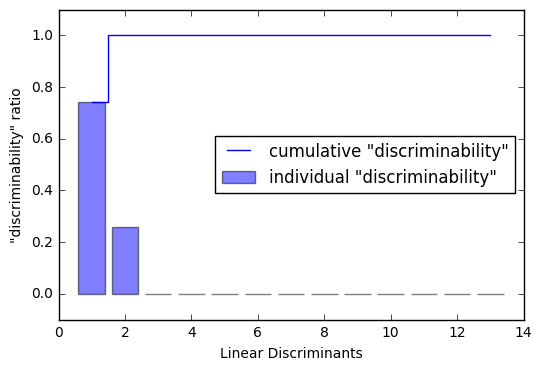

In [161]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

# 7. Project X onto new dimension using projection matrix W

In [175]:
# Let's now stack 2 most discriminative eigenvector columns to create weight matrix
# or transformation matrix
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
X_train_lda = X_train_std.dot(w)

# If we plot X_train_lda, we can make out that its now linearly separable.

# 8. Now that we know the inner's of lda implementation, lets try scikit's LDA

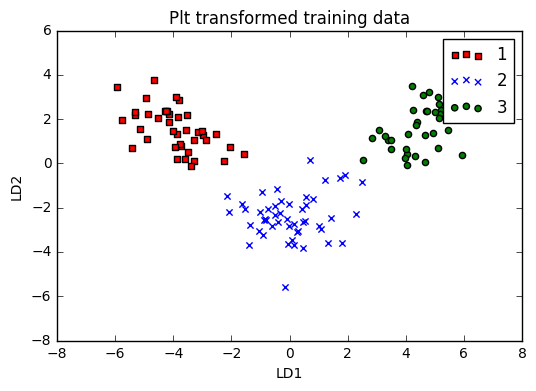

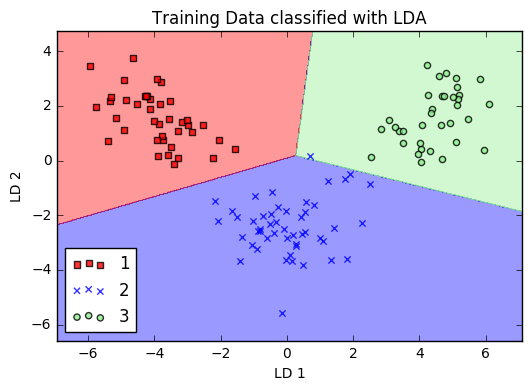

In [181]:
from sklearn.lda import LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

# plot X_train_lda to verify that its now linearly separable
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l,c,m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)

plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(loc="upper right")
plt.title("Plt transformed training data")
plt.show()

# fit X_train_lda with logisticRegression
from sklearn.linear_model import LogisticRegression
% run 'plot_decision_regions.ipynb'
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title("Training Data classified with LDA")
plt.show()

# 9. Classify Test Data now

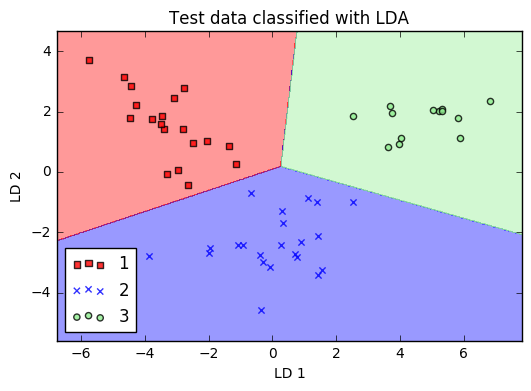

In [180]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.title("Test data classified with LDA")
plt.show()